# Cyber Threat Hunting - Chapter 8

# Scenario

## Getting comfortable with the data

#### Listing 8.2 Jupyter notebook code — Retrieve data from the datastore

In [1]:
import pandas as pd

df_original = pd.read_json("ch7_stream_events.json")
print(len(df_original))

320044


In [2]:
df_original.columns

Index(['bytes_in', '#type', 'dest_mac', '#repo', 'src_ip', '@sourcetype',
       'endtime', '@timezone', '@rawstring', '@id', '@timestamp',
       '@ingesttimestamp', 'timestamp', '@error', 'src_port', 'time_taken',
       'cribl_pipe', '@error_msg', 'dest_ip', 'transport', 'bytes',
       'transaction_id', '#error', 'dest_port', 'src_mac', 'protocol_stack',
       'bytes_out', 'flow_id', '@timestamp.nanos', 'packets_in', 'app',
       'packets_out', 'protocol', 'tos', 'fragment_count', 'version',
       'protoid', 'connection', 'refused', 'tcp_status', 'client_rtt_sum',
       'data_packets_in', 'server_rtt', 'server_rtt_packets',
       'duplicate_packets_in', 'data_packets_out', 'duplicate_packets_out',
       'ack_packets_out', 'ack_packets_in', 'missing_packets_in',
       'client_rtt_packets', 'missing_packets_out', 'client_rtt',
       'server_rtt_sum', 'initial_rtt', 'ssl_cert_self_signed',
       'ssl_cert_sha1', 'ssl_cert_md5', 'ssl_validity_start', 'ssl_issuer',
       'ssl_

In [3]:
columns_to_keep = ['app', 'src_ip', 'src_port', 'timestamp',\
    'endtime' , 'dest_port', 'dest_ip', 'bytes', 'bytes_in', \
        'bytes_out', '@sourcetype']

df = df_original[columns_to_keep]
df.head()

,app,src_ip,src_port,timestamp,endtime,dest_port,dest_ip,bytes,bytes_in,bytes_out,@sourcetype
0,NaN,52.151.54.66,64964.0,2022-09-19 17:10:13.032630+00:00,2022-09-19T17:10:13.032630Z,3389.0,10.0.0.4,32.0,32,0.0,stream:dns
1,NaN,13.84.149.211,59082.0,2022-09-19 14:15:22.282843+00:00,2022-09-19T14:15:22.282843Z,3389.0,10.0.0.13,32.0,32,0.0,stream:dns
2,NaN,20.106.221.251,61571.0,2022-09-19 13:35:55.049369+00:00,2022-09-19T13:35:55.049369Z,3389.0,10.0.0.13,32.0,32,0.0,stream:dns
3,NaN,52.151.52.236,56546.0,2022-09-19 13:35:52.852283+00:00,2022-09-19T13:35:52.852283Z,3389.0,10.0.0.4,32.0,32,0.0,stream:dns
4,dropbox,10.0.0.18,17500.0,2022-09-19 20:59:58.337959+00:00,2022-09-19T20:59:58.337959Z,17500.0,255.255.255.255,175.0,175,0.0,stream:udp


#### Listing 8.3 Jupyter notebook code — Calculate new variables

In [4]:
count_threshold = 100
df = df.groupby(['src_ip', 'dest_ip', 'dest_port']).filter \
    (lambda x : len(x)>count_threshold)
df = df.reset_index()
print(len(df.index), "records with count >", count_threshold)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
df['endtime'] = pd.to_datetime(df['endtime'], format='mixed')
df['epoch_timestamp'] = df['timestamp'].astype('int64') // 10**9
df['epoch_endtime'] = df['endtime'].astype('int64') // 10**9

df = df.sort_values(by=['epoch_timestamp'], ascending=True)
df['epoch_timestamp'] = df['epoch_timestamp'].astype(int)
df['epoch_endtime'] = df['epoch_endtime'].astype(int)
df['bytes'] = df['bytes'].astype(int)
df['bytes_in'] = df['bytes_in'].astype(int)
df.dtypes

df['time_diff_sec'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['epoch_timestamp'].transform(lambda x: x - x.shift(1))

df['bytes_diff'] = df['bytes_in'] - df['bytes_out']

df['std1'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['time_diff_sec'].transform('std')
df['var1'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['time_diff_sec'].transform('var')
df['count1'] = df.groupby(['src_ip', 'dest_ip', 'dest_port'])\
    ['time_diff_sec'].transform('count')
df[['var1','std1']].sort_values(by=['std1'], ascending=True)

268465 records with count > 100


,var1,std1
258597,5.847953e-03,0.076472
233752,5.847953e-03,0.076472
248169,5.847953e-03,0.076472
10005,5.847953e-03,0.076472
199891,5.847953e-03,0.076472
...,...,...
122485,1.160147e+06,1077.101422
64209,1.160147e+06,1077.101422
114491,1.160147e+06,1077.101422
64056,1.160147e+06,1077.101422


#### Listing 8.4 Jupyter notebook code — Return the dominions of df

In [5]:
df.shape                                                                 

(268465, 19)

## Exploring and processing the dataset

#### Listing 8.5 Jupyter notebook code — Store features in a new DataFrame, df_features

In [6]:
df_features = df[['bytes', 'app', 'std1', 'bytes_diff', 'count1']]

## Looking for empty fields

#### Listing 8.6 Jupyter notebook code — Return the number of empty cells per column and drop ones with null values

In [7]:
df_features.isnull().sum()

bytes              0
app           108771
std1               0
bytes_diff         0
count1             0
dtype: int64

In [8]:
df_features.dropna(subset=['app'], inplace=True)
df_features.isnull().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_7200\1259264590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.dropna(subset=['app'], inplace=True)


bytes         0
app           0
std1          0
bytes_diff    0
count1        0
dtype: int64

In [9]:
df_features.shape

(159694, 5)

## Looking for fields with a large number of unique values

#### Listing 8.7 Jupyter notebook code — Return the number of empty cells per column

In [10]:
df_features.nunique()

bytes         829
app            13
std1           72
bytes_diff    800
count1         48
dtype: int64

#### Listing 8.8 Jupyter notebook code — Label Encoding for field app

## Looking for highly correlated fields

#### Listing 8.8 Jupyter notebook code — Label Encoding for field app

In [11]:
df_features_label_enc = df_features[['bytes', 'app', 'std1',\
    'bytes_diff', 'count1']]
df_features_label_enc['app_cat'] =  \
    df_features_label_enc["app"].astype('category').cat.codes
df_features_label_enc.head()

,bytes,app,std1,bytes_diff,count1,app_cat
10134,11017,ssl,35.735449,-2785.0,171,5
10707,8443,ssl,0.138973,-2589.0,156,5
10711,9127,ssl,0.152499,-2803.0,172,5
10386,430,unknown,0.079809,-16.0,157,8
10592,39797,windows_azure,6.585435,37475.0,7084,10


#### Listing 8.9 Jupyter notebook code — Applying One Hot Encoding on field app

In [12]:
df_features_one_hot_enc = pd.get_dummies(df_features, columns=['app'])
list(df_features_one_hot_enc)

['bytes',
 'std1',
 'bytes_diff',
 'count1',
 'app_dns',
 'app_dropbox',
 'app_http',
 'app_rpc',
 'app_splunk',
 'app_ssl',
 'app_tcp',
 'app_udp',
 'app_unknown',
 'app_unknown-ssl',
 'app_windows_azure',
 'app_windows_marketplace',
 'app_windows_update']

## Calculating correlation

#### Listing 8.11 Jupyter notebook code — Generate the pairwise correlation heat map for the df_features_one_hot_enc

<Axes: >

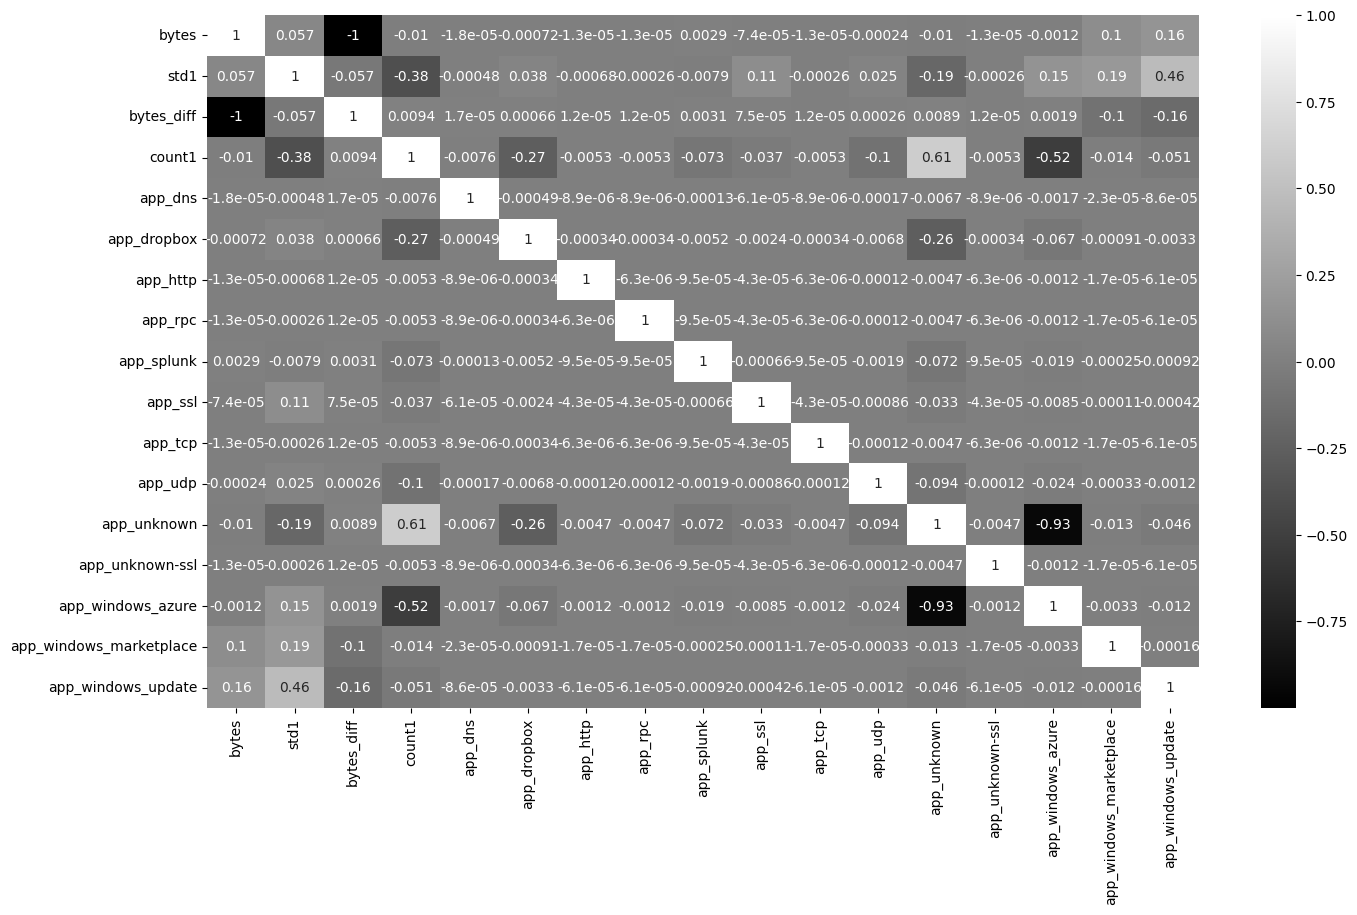

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,9))
sns.heatmap(df_features_one_hot_enc.corr(method='pearson'),\
    annot=True, cmap='gray')


#### Listing 8.12 Jupyter notebook code — Drop highly correlated fields

In [14]:
df_features_one_hot_enc = df_features_one_hot_enc.drop(['bytes_diff',\
    'app_unknown', 'app_windows_update'], axis='columns')

<Axes: >

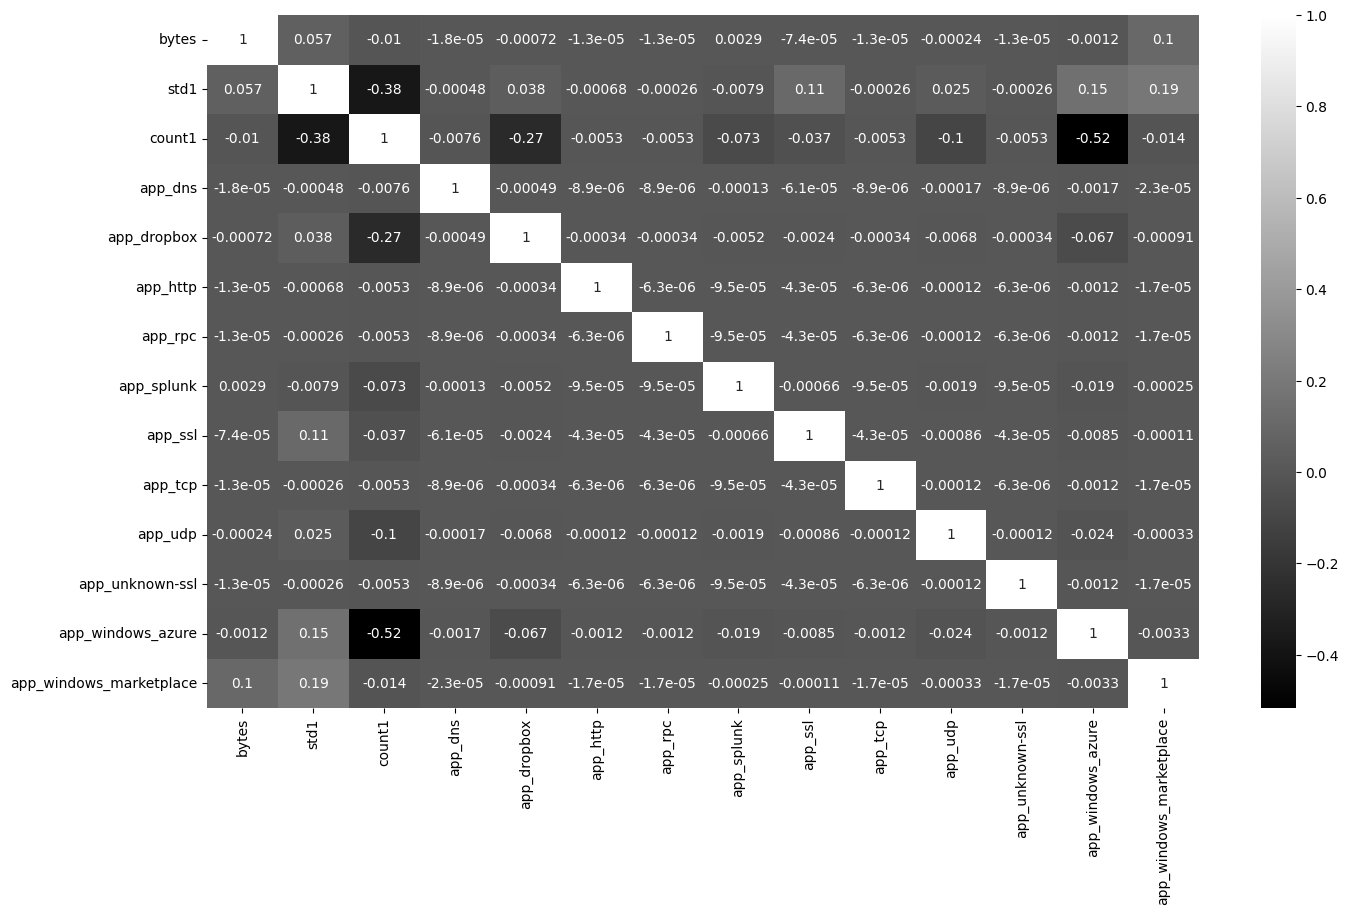

In [15]:
plt.figure(figsize=(16,9))
sns.heatmap(df_features_one_hot_enc.corr(method='pearson'),\
    annot=True, cmap='gray')

## Feature scaling

#### Listing 8.13 Jupyter notebook code — Scaling the features in df_features_one_hot_enc

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_features_one_hot_enc['bytes'] = \
    scaler.fit_transform(df_features_one_hot_enc[['bytes']])
df_features_one_hot_enc['std1'] = \
    scaler.fit_transform(df_features_one_hot_enc[['std1']])
df_features_one_hot_enc['count1'] = \
    scaler.fit_transform(df_features_one_hot_enc[['count1']])

df_features_one_hot_enc.head()

,bytes,std1,count1,app_dns,app_dropbox,app_http,app_rpc,app_splunk,app_ssl,app_tcp,app_udp,app_unknown-ssl,app_windows_azure,app_windows_marketplace
10134,0.003270,0.687013,-2.159939,False,False,False,False,False,True,False,False,False,False,False
10707,0.001234,-0.320883,-2.163017,False,False,False,False,False,True,False,False,False,False,False
10711,0.001775,-0.320500,-2.159734,False,False,False,False,False,True,False,False,False,False,False
10386,-0.005104,-0.322558,-2.162812,False,False,False,False,False,False,False,False,False,False,False
10592,0.026035,-0.138355,-0.741360,False,False,False,False,False,False,False,False,False,True,False


## Determining the number of clusters, k

#### Listing 8.14 Jupyter notebook code — Generate pairwise plots for the columns (features) in df_features_one_hot_enc

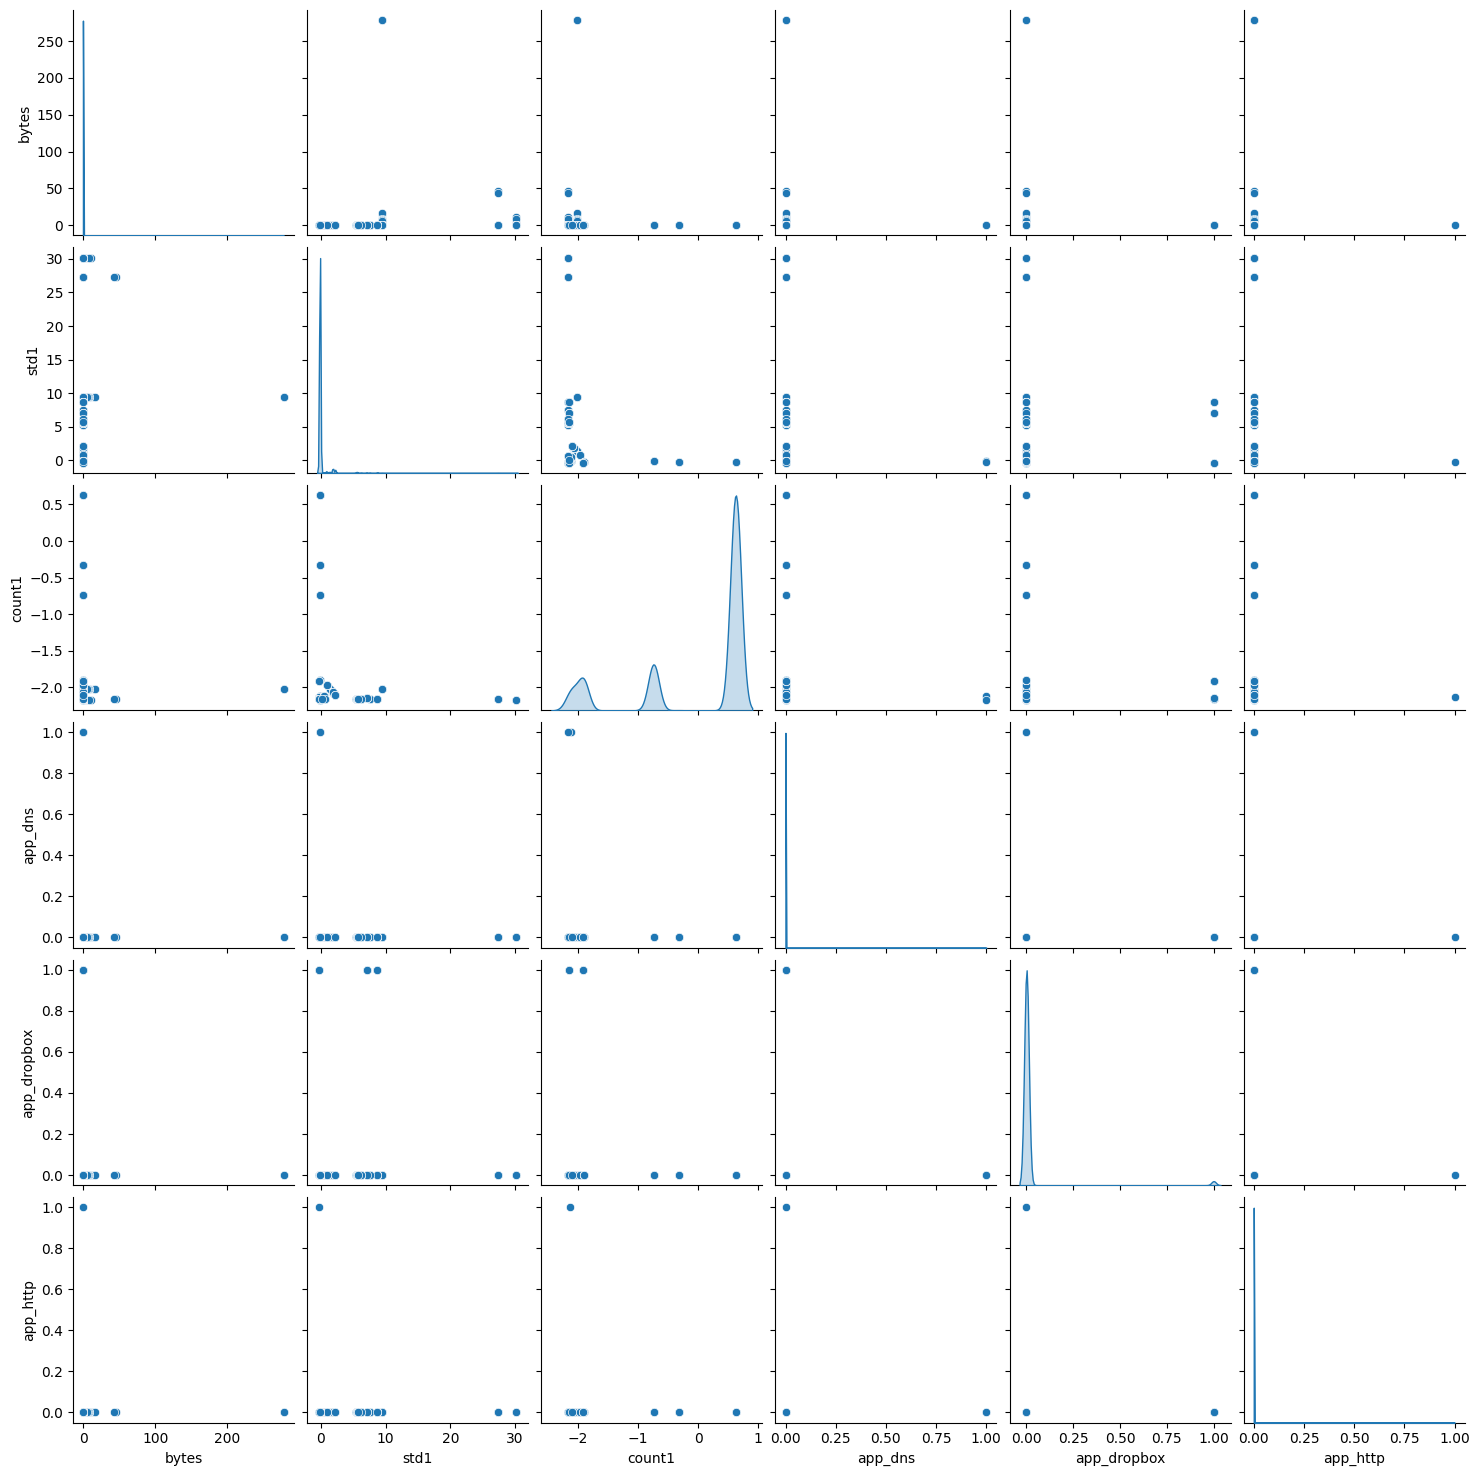

In [17]:
sns.pairplot(df_features_one_hot_enc, vars=\
    ['bytes', 'std1', 'count1', 'app_dns', 'app_dropbox',\
        'app_http'], diag_kind='kde')
plt.show()

#### Listing 8.15 Jupyter notebook code — Apply the elbow method to df_features_one_hot_enc

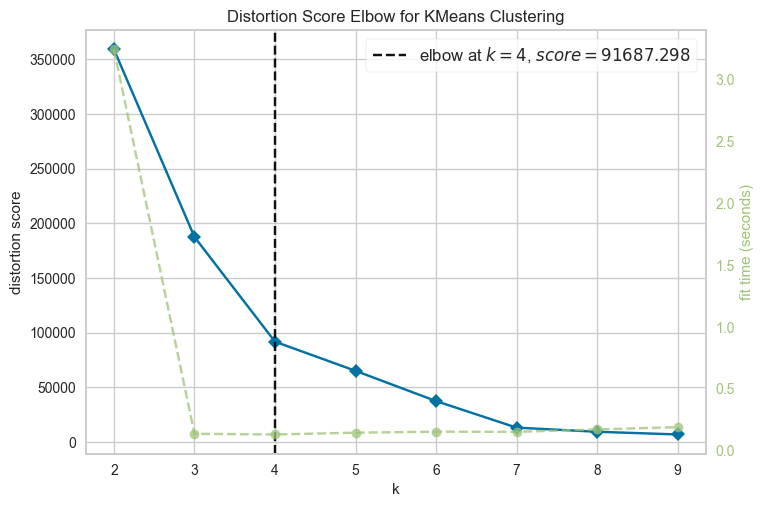

CPU times: total: 6.41 s
Wall time: 11.4 s


<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
%%time
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(df_features_one_hot_enc)
visualizer.show()

## Applying K-Means clustering

#### Listing 8.16 Jupyter notebook code — Apply K-Means on df_features_one_hot_enc

In [20]:
%%time
km = KMeans(n_clusters = 4)
km.fit(df_features_one_hot_enc)
df_features_one_hot_enc['cluster'] = km.labels_
df_features_one_hot_enc.head()

CPU times: total: 203 ms
Wall time: 167 ms


,bytes,std1,count1,app_dns,app_dropbox,app_http,app_rpc,app_splunk,app_ssl,app_tcp,app_udp,app_unknown-ssl,app_windows_azure,app_windows_marketplace,cluster
10134,0.003270,0.687013,-2.159939,False,False,False,False,False,True,False,False,False,False,False,3
10707,0.001234,-0.320883,-2.163017,False,False,False,False,False,True,False,False,False,False,False,3
10711,0.001775,-0.320500,-2.159734,False,False,False,False,False,True,False,False,False,False,False,3
10386,-0.005104,-0.322558,-2.162812,False,False,False,False,False,False,False,False,False,False,False,3
10592,0.026035,-0.138355,-0.741360,False,False,False,False,False,False,False,False,False,True,False,3


#### Listing 8.17 Jupyter notebook code — Plot clusters using features bytes and std1

c:\Users\User\Documents\Cyber_Threat_Hunting\cth\Lib\site-packages\seaborn\regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


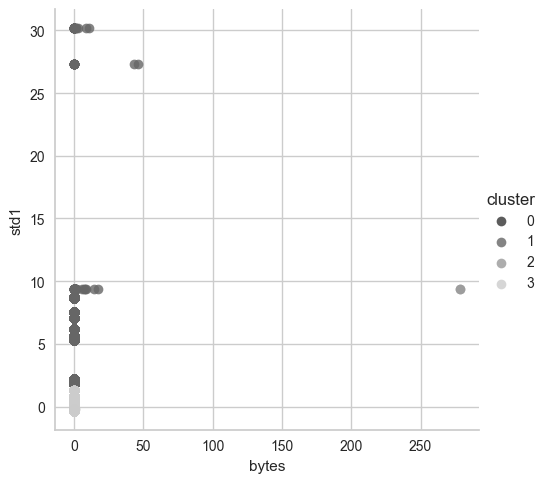

In [21]:
clusters = df_features_one_hot_enc['cluster'].nunique()
gray_palette = sns.color_palette("gray", clusters)
sns.lmplot(data=df_features_one_hot_enc, x='bytes', y='std1',\
    hue='cluster', palette=gray_palette, fit_reg=False, legend=True,\
        legend_out=True)
plt.show()

c:\Users\User\Documents\Cyber_Threat_Hunting\cth\Lib\site-packages\seaborn\regression.py:598: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


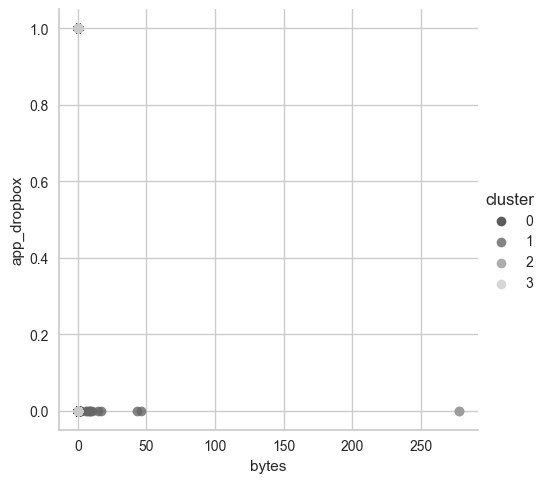

In [22]:
clusters = df_features_one_hot_enc['cluster'].nunique()
gray_palette = sns.color_palette("gray", clusters)
sns.lmplot(data=df_features_one_hot_enc, x='bytes', y='app_dropbox', hue='cluster', palette=gray_palette, fit_reg=False, legend=True, legend_out=True)
plt.show()

#### Listing 8.18 Jupyter notebook code — Count and plot the number of data points in each cluster

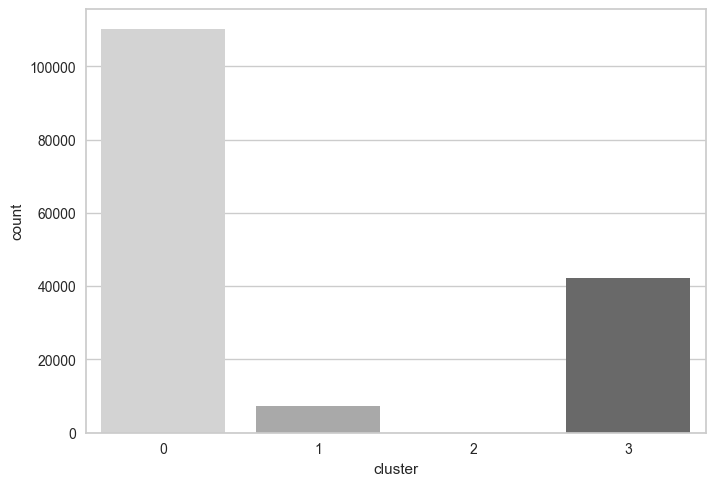

In [23]:
gray_palette = ['#D3D3D3', '#A9A9A9', '#808080', '#696969']
sns.countplot(x='cluster', hue='cluster', data=df_features_one_hot_enc, palette=gray_palette, dodge=False, legend=False)
plt.show()

#### Listing 8.19 Jupyter notebook code — Count the number of data points in each cluster

In [24]:
df_features_one_hot_enc.value_counts('cluster')

cluster
0    110085
3     42279
1      7328
2         2
Name: count, dtype: int64

#### Listing 8.21 Jupyter notebook output — Display a pie chart showing the size of the clusters in percentage

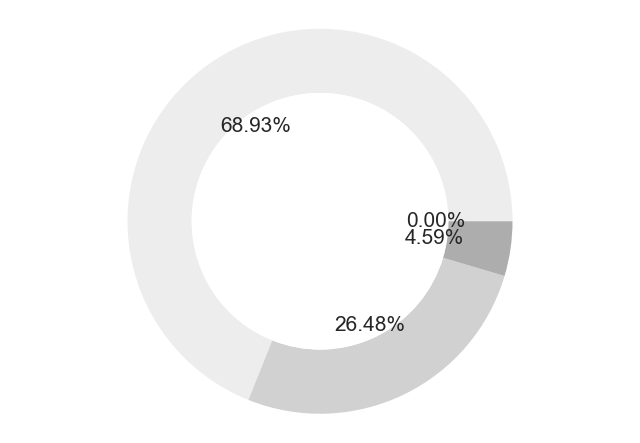

In [25]:
plt.pie(df_features_one_hot_enc.value_counts('cluster'), 
        colors=sns.color_palette('Greys'), 
        autopct='%0.2f%%', 
        radius=3, 
        textprops={"fontsize": 15},
        wedgeprops={'width': 1}
       )

centre_circle = plt.Circle((0,0), 2, color='black',\
        fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

## 8.3	Analyzing clusters of interest

#### Listing 8.22 Jupyter notebook output — Copy the content of column from df_features_one_hot_enc to a new column, cluster, in df

In [26]:
df['cluster'] = df_features_one_hot_enc['cluster']

## Cluster two (2)

#### Listing 8.23 Jupyter notebook code — Exclude normal traffic by destination port and IP addresses for cluster two (2)

In [27]:
df[
    (df.cluster == 2) \
    & (df['src_ip'].str.startswith('10.')) \
    & (df['dest_port'] != 9997) \
    & (~df['dest_ip'].str.endswith(".255")) \
    & (~df['dest_ip'].str.contains("20.7.1")) \
    & (~df['dest_ip'].str.contains("20.7.2")) \
    & (~df['dest_ip'].str.contains("20.10.31.115")) \
    & (~df['dest_ip'].str.contains("168.63.129.16")) \
    & (~df['dest_ip'].str.contains("169.254.169.254")) \
    & (~df['dest_ip'].str.contains("239.255.255.250")) \
    & (~df['dest_ip'].str.contains("13.107.4.50")) \
].groupby(['src_ip', 'dest_ip', 'dest_port', 'std1', 'count1']).size()

Series([], dtype: int64)

## Cluster one (1)

#### Listing 8.25 Jupyter notebook code — Exclude normal traffic by destination port and IP addresses for cluster zero (0)

In [28]:
df[
    (df.cluster == 1) \
    & (df['src_ip'].str.startswith('10.')) \
    & (df['dest_port'] != 9997) \
    & (~df['dest_ip'].str.endswith(".255")) \
    & (~df['dest_ip'].str.contains("20.7.1")) \
    & (~df['dest_ip'].str.contains("20.7.2")) \
    & (~df['dest_ip'].str.contains("20.10.31.115")) \
    & (~df['dest_ip'].str.contains("168.63.129.16")) \
    & (~df['dest_ip'].str.contains("169.254.169.254")) \
    & (~df['dest_ip'].str.contains("239.255.255.250")) \
    & (~df['dest_ip'].str.contains("13.107.4.50")) \
].groupby(['src_ip', 'dest_ip', 'dest_port', 'std1', 'count1']).size()

src_ip     dest_ip       dest_port  std1        count1
10.0.0.12  40.87.160.0   23456.0    206.440273  201       202
10.0.0.13  40.87.160.0   23456.0    230.159154  168       169
10.0.0.15  40.87.160.0   23456.0    208.076508  194       195
10.0.0.16  40.87.160.0   23456.0    277.237105  157       158
10.0.0.18  162.125.2.14  443.0      260.327212  237       238
           40.87.160.0   23456.0    211.475951  197       198
10.0.0.4   162.125.2.14  443.0      318.094573  188       189
           40.87.160.0   23456.0    319.823560  147       148
10.0.0.8   40.87.160.0   23456.0    200.073430  164       165
10.0.0.9   40.87.160.0   23456.0    206.276419  171       172
dtype: int64

In [29]:
df[
    (df.cluster == 1) \
    & (df['src_ip'].str.startswith('10.')) \
    & (df['dest_port'] != 9997) \
    & (~df['dest_ip'].str.endswith(".255")) \
    & (~df['dest_ip'].str.contains("20.7.1")) \
    & (~df['dest_ip'].str.contains("20.7.2")) \
    & (~df['dest_ip'].str.contains("20.10.31.115")) \
    & (~df['dest_ip'].str.contains("168.63.129.16")) \
    & (~df['dest_ip'].str.contains("169.254.169.254")) \
    & (~df['dest_ip'].str.contains("239.255.255.250")) \
    & (~df['dest_ip'].str.contains("13.107.4.50")) \
    & (~df['dest_ip'].str.contains("40.87.160.0")) \
].groupby(['src_ip', 'dest_ip', 'dest_port', 'std1', 'count1']).size()

src_ip     dest_ip       dest_port  std1        count1
10.0.0.18  162.125.2.14  443.0      260.327212  237       238
10.0.0.4   162.125.2.14  443.0      318.094573  188       189
dtype: int64

## Silhouette analysis as an alternative to the elbow method

#### Listing 8.28 Jupyter notebook code — Apply silhouette analysis to df_features_one_hot_enc

In [30]:
df_features_one_hot_enc.columns

Index(['bytes', 'std1', 'count1', 'app_dns', 'app_dropbox', 'app_http',
       'app_rpc', 'app_splunk', 'app_ssl', 'app_tcp', 'app_udp',
       'app_unknown-ssl', 'app_windows_azure', 'app_windows_marketplace',
       'cluster'],
      dtype='object')

In [31]:
df_features_one_hot_enc = df_features_one_hot_enc.drop(['cluster'],\
    axis='columns')

52minutes

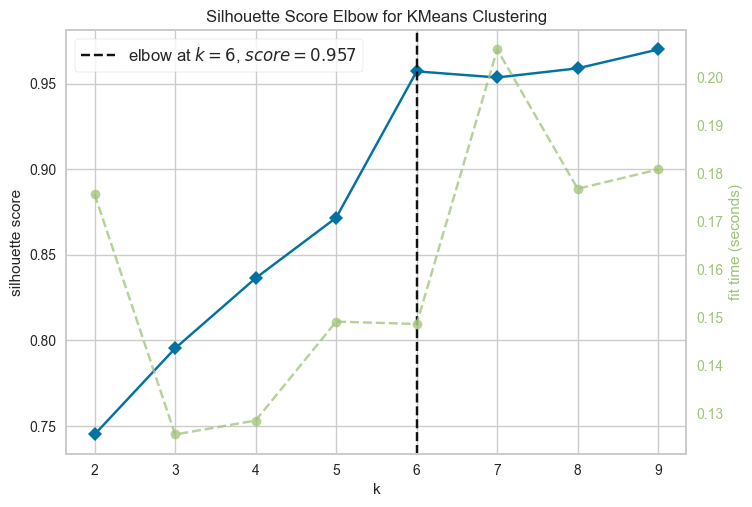

CPU times: total: 1h 39min 23s
Wall time: 49min 3s


In [32]:
%%time
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(df_features_one_hot_enc)
visualizer.show()
plt.show()

## K-Means with k=6

#### Listing 8.29 Jupyter notebook code — Apply K-Means on df_features_one_hot_enc with k=6

In [33]:
km = KMeans(n_clusters = 6)
km.fit(df_features_one_hot_enc)
df_features_one_hot_enc['cluster'] = km.labels_

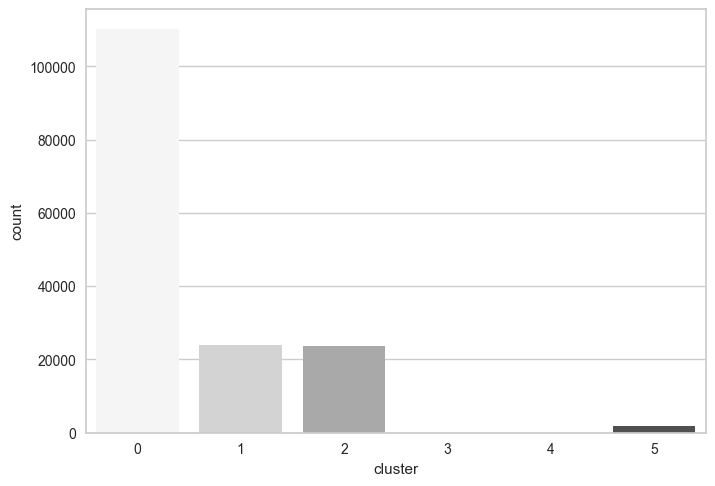

In [34]:
gray_palette = ['#F5F5F5', '#D3D3D3', '#A9A9A9', '#808080',\
    '#696969', '#505050']
sns.countplot(x='cluster', hue='cluster', \
    data=df_features_one_hot_enc, palette=gray_palette,\
        dodge=False, legend=False)
plt.show()

In [35]:
df['cluster'] = df_features_one_hot_enc['cluster']

## 8.5.1	Cluster three

#### Listing 8.30 Jupyter notebook code — Exclude normal traffic by destination port and IP addresses for cluster two (2)

In [58]:
df[
    (df.cluster == 3) \
    & (df['src_ip'].str.startswith('10.')) \
    & (df['dest_port'] != 9997) \
    & (~df['dest_ip'].str.endswith(".255")) \
    & (~df['dest_ip'].str.contains("20.7.1")) \
    & (~df['dest_ip'].str.contains("20.7.2")) \
    & (~df['dest_ip'].str.contains("20.10.31.115")) \
    & (~df['dest_ip'].str.contains("168.63.129.16")) \
    & (~df['dest_ip'].str.contains("169.254.169.254")) \
    & (~df['dest_ip'].str.contains("239.255.255.250")) \
    & (~df['dest_ip'].str.contains("13.107.4.50")) \
].groupby(['src_ip', 'dest_ip', 'dest_port', 'std1', 'count1']).size()

Series([], dtype: int64)

## Cluster five

#### Listing 8.31 Jupyter notebook code — Exclude normal traffic by destination port and IP addresses for cluster four (4)

In [67]:
df[
    (df.cluster == 5) \
    & (df['src_ip'].str.startswith('10.')) \
    & (df['dest_port'] != 9997) \
    & (~df['dest_ip'].str.endswith(".255")) \
    & (~df['dest_ip'].str.contains("20.7.1")) \
    & (~df['dest_ip'].str.contains("20.7.2")) \
    & (~df['dest_ip'].str.contains("20.10.31.115")) \
    & (~df['dest_ip'].str.contains("168.63.129.16")) \
    & (~df['dest_ip'].str.contains("169.254.169.254")) \
    & (~df['dest_ip'].str.contains("239.255.255.250")) \
    & (~df['dest_ip'].str.contains("13.107.4.50")) \
].groupby(['src_ip', 'dest_ip', 'dest_port', 'std1', 'count1']).size()

src_ip     dest_ip       dest_port  std1        count1
10.0.0.12  40.87.160.0   23456.0    206.440273  201       202
10.0.0.13  40.87.160.0   23456.0    230.159154  168       169
10.0.0.15  40.87.160.0   23456.0    208.076508  194       195
10.0.0.16  40.87.160.0   23456.0    277.237105  157       158
10.0.0.18  162.125.2.14  443.0      260.327212  237       238
           40.87.160.0   23456.0    211.475951  197       198
10.0.0.4   162.125.2.14  443.0      318.094573  188       189
           40.87.160.0   23456.0    319.823560  147       148
10.0.0.8   40.87.160.0   23456.0    200.073430  164       165
10.0.0.9   40.87.160.0   23456.0    206.276419  171       172
dtype: int64

## Cluster one

#### Listing 8.33 Jupyter notebook code — Exclude normal traffic by destination port and IP addresses for cluster one (1)

In [68]:
df[
    (df.cluster == 4) \
    & (df['src_ip'].str.startswith('10.')) \
    & (df['dest_port'] != 9997) \
    & (~df['dest_ip'].str.endswith(".255")) \
    & (~df['dest_ip'].str.contains("20.7.1")) \
    & (~df['dest_ip'].str.contains("20.7.2")) \
    & (~df['dest_ip'].str.contains("20.10.31.115")) \
    & (~df['dest_ip'].str.contains("168.63.129.16")) \
    & (~df['dest_ip'].str.contains("169.254.169.254")) \
    & (~df['dest_ip'].str.contains("239.255.255.250")) \
    & (~df['dest_ip'].str.contains("13.107.4.50")) \
].groupby(['src_ip', 'dest_ip', 'dest_port', 'std1', 'count1']).size()

Series([], dtype: int64)

# Answers to Exercise

#### Listing 8.34 Jupyter notebook code — Apply silhouette analysis with k=(2,12)

In [69]:
df_features_one_hot_enc = df_features_one_hot_enc.drop(['cluster'],\
    axis='columns')

60minutes

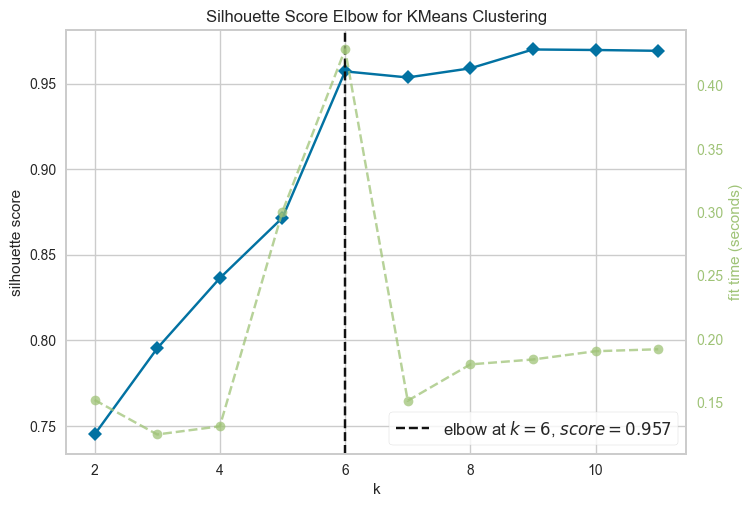

CPU times: total: 2h 4min 17s
Wall time: 1h 13min 11s


In [70]:
%%time
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette')

visualizer.fit(df_features_one_hot_enc)
visualizer.show()
plt.show()

#### Listing 8.35 Jupyter notebook code — Apply the elbow method with k=(2,12)

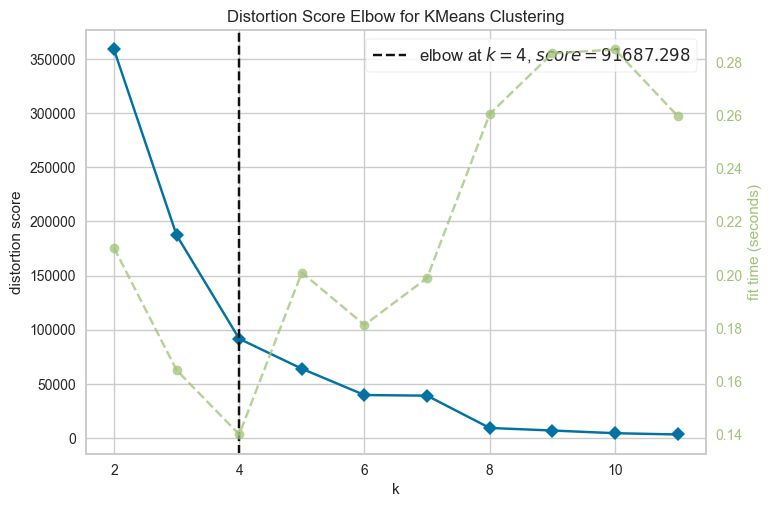

CPU times: total: 7.34 s
Wall time: 4.09 s


In [71]:
%%time
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(df_features_one_hot_enc)
visualizer.show()
plt.show()

#### Listing 8.36 Jupyter notebook code — Apply K-Means on df_features_one_hot_enc with k=10)

In [72]:
km = KMeans(n_clusters = 10)
km.fit(df_features_one_hot_enc)


KMeans(n_clusters=10)

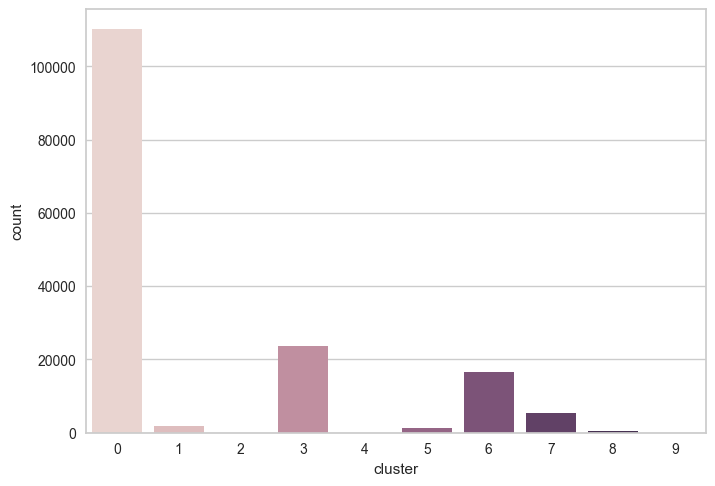

In [73]:
df_features_one_hot_enc['cluster'] = km.labels_
sns.countplot(x='cluster', hue='cluster', \
    data=df_features_one_hot_enc,\
        dodge=False, legend=False)
plt.show()